In [1]:
import torch
import numpy as np
import cv2
import os

from detectron2.checkpoint import DetectionCheckpointer
from detectron2.config import get_cfg
from detectron2.utils.logger import setup_logger
from detectron2.evaluation import inference_context
import detectron2.data.detection_utils as utils

# for inpainting
from deepfill.config import add_inpainter_config
from deepfill.train_loop import InpainterTrainer
import deepfill.dataset
import deepfill.inpnet

# tools for visualization
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (18.0, 18.0) # set default size of plots

In [2]:
plt.rcParams['figure.figsize'] = (18.0, 18.0) # this seems to be called twice

In [3]:
# set configuration
config_file = "./configs/pretrained_eval.yaml"
cfg = get_cfg()
add_inpainter_config(cfg)
cfg.merge_from_file(config_file)
cfg.freeze()

# load model
model = InpainterTrainer.build_model(cfg)
DetectionCheckpointer(model, save_dir=cfg.OUTPUT_DIR).resume_or_load(cfg.MODEL.WEIGHTS, resume=False)

Config './configs/pretrained_eval.yaml' has no VERSION. Assuming it to be compatible with latest v2.


{}

In [4]:
def run_inpainting_on_image(im_file_name, mask_file_name, save_dir=None):
    # get input data to the model
    dataset_dict = {}
    image = utils.read_image(im_file_name, format="RGB")  # this will be returned
    # model requires "BGR" image as input
    dataset_dict["image"] = torch.as_tensor(image[:, :, ::-1].transpose(2, 0, 1).astype("float32"))
    mask = cv2.imread(mask_file_name)  # this will be used to erase image that will be returned
    mask = (mask[:, :, 0] > 127.5)
    dataset_dict["mask"] = torch.as_tensor(mask.astype(np.float32)[None])  # (1, H, W)
    dataset_dict["height"] = image.shape[0]
    dataset_dict["width"] = image.shape[1]
    
    # forward
    with inference_context(model), torch.no_grad():
        outputs = model([dataset_dict])
    
    # convert outputs to RGB image
    inpainted_im = np.array(outputs[0]["inpainted"].to(torch.device("cpu")), dtype=np.float32)
    inpainted_im = np.transpose((inpainted_im + 1.) * 127.5, (1, 2, 0))
    inpainted_im = inpainted_im.astype(np.uint8)  # this is a BGR image
    
    # dump the inpainted image
    if save_dir is not None:
        file_name = os.path.basename(im_file_name)
        out_file_name = file_name.replace("input", "output")
        cv2.imwrite(os.path.join(save_dir, out_file_name), inpainted_im)
    
    return image, image * (1 - mask[:, :, None].astype(np.uint8)), inpainted_im[:, :, ::-1]

def visualize_on_image(im_file_name, mask_file_name, save_dir=None):
    im, masked_im, inpainted_im = run_inpainting_on_image(im_file_name, mask_file_name, save_dir)
    for i, to_show in enumerate([im, masked_im, inpainted_im]):
        plt.subplot(1, 3, i+1)
        plt.imshow(to_show)
        
dump_dir = "./demo_outputs"
os.makedirs(dump_dir, exist_ok=True)

/home/s2006466/anaconda3/envs/py3.6/lib/python3.6/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


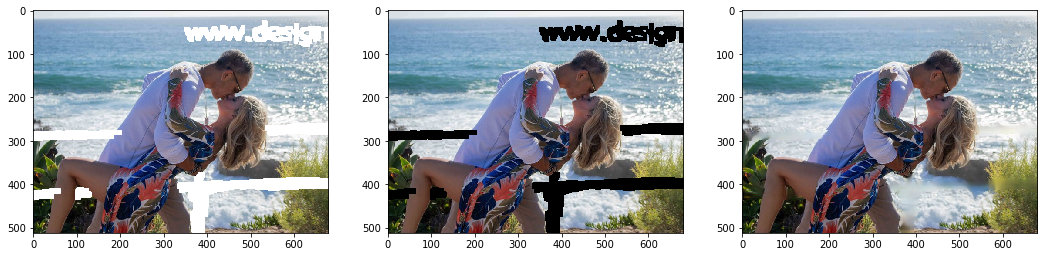

In [5]:
visualize_on_image("./examples/places2/case1_input.png", "./examples/places2/case1_mask.png", save_dir=dump_dir)

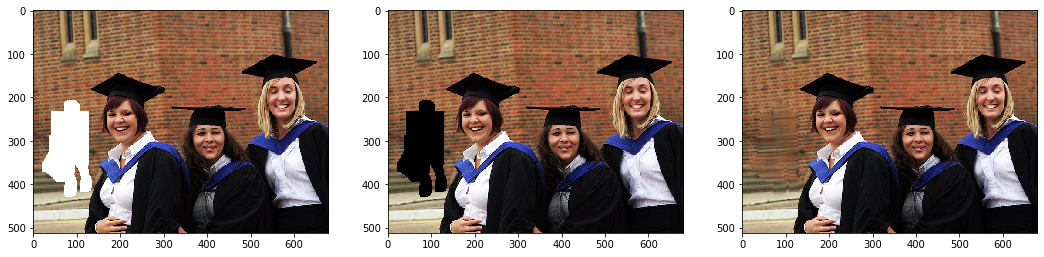

In [21]:
visualize_on_image("./examples/places2/case2_input.png", "./examples/places2/case2_mask.png", save_dir=dump_dir)

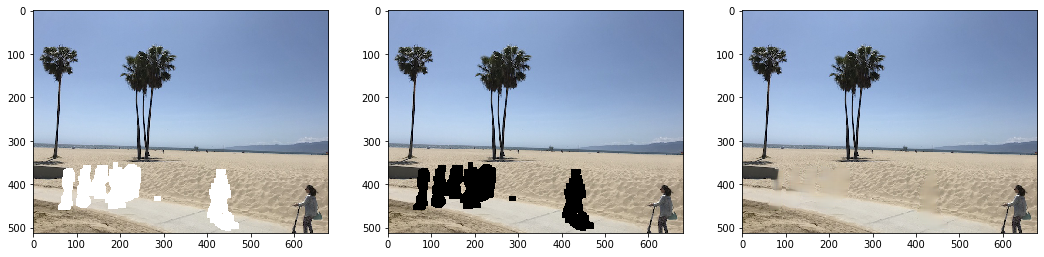

In [22]:
visualize_on_image("./examples/places2/case3_input.png", "./examples/places2/case3_mask.png", save_dir=dump_dir)

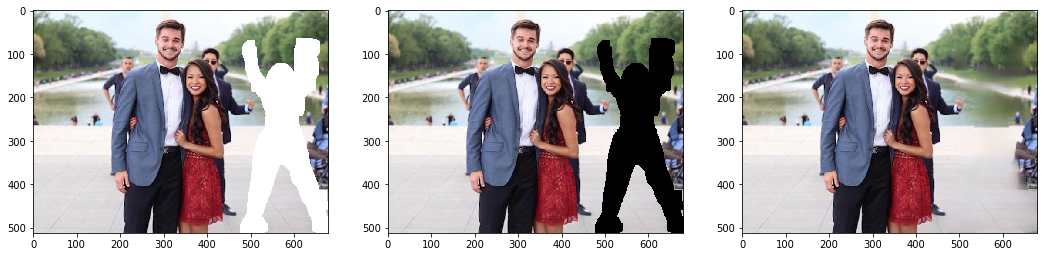

In [23]:
visualize_on_image("./examples/places2/case4_input.png", "./examples/places2/case4_mask.png", save_dir=dump_dir)

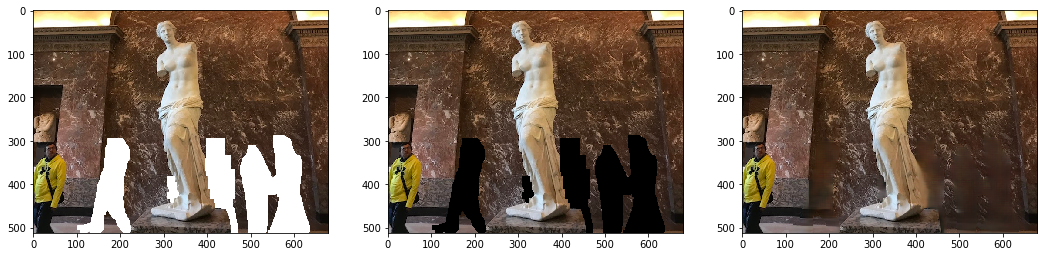

In [24]:
visualize_on_image("./examples/places2/case5_input.png", "./examples/places2/case5_mask.png", save_dir=dump_dir)

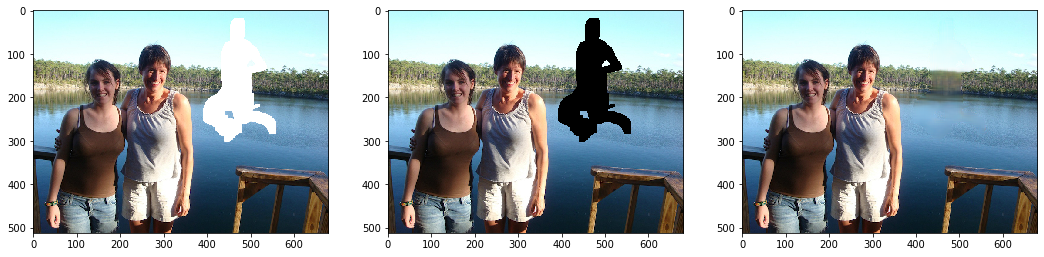

In [25]:
visualize_on_image("./examples/places2/case6_input.png", "./examples/places2/case6_mask.png", save_dir=dump_dir)